### **BPIC 2012 - A_PREACCEPTED**


In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from data.processor import *
from data.args import *

from tensorflow.keras.utils import to_categorical


### Define the experiment parameters

In [3]:
milestone = 'A_PREACCEPTED' #'A_PREACCEPTED' # 'W_Nabellen offertes','W_Valideren aanvraag', 'All'
experiment =  'OHE'#'Standard'#'OHE', 'No_loops'
n_size = 5

### Setting up the key parameters


In [4]:
# For local environment only

MY_WORKSPACE_DIR = os.path.join(os.getcwd(),'BPIC12')
MILESTONE_DIR = os.path.join(os.path.join(MY_WORKSPACE_DIR, milestone),experiment)

In [5]:
args = get_parameters('bpic12', MILESTONE_DIR, MY_WORKSPACE_DIR, milestone, experiment,n_size)
args

{'folder': 'c:\\Users\\20182009\\Documents\\Master DSAI\\y2 q1\\2IMI00 seminar process analytics\\replicationStudy\\Shared-and-Specialised-Attention-based-Interpretable-Models\\BPIC12\\A_PREACCEPTED\\OHE\\output_files',
 'lstm_act': None,
 'dense_act': None,
 'optim': 'Adam',
 'norm_method': 'lognorm',
 'model_type': 'shared_cat',
 'l_size': 50,
 'n_size': 5,
 'file_name': 'c:\\Users\\20182009\\Documents\\Master DSAI\\y2 q1\\2IMI00 seminar process analytics\\replicationStudy\\Shared-and-Specialised-Attention-based-Interpretable-Models\\BPIC12\\BPIC_2012_Prefixes.csv',
 'file_name_all': 'c:\\Users\\20182009\\Documents\\Master DSAI\\y2 q1\\2IMI00 seminar process analytics\\replicationStudy\\Shared-and-Specialised-Attention-based-Interpretable-Models\\BPIC12\\BPIC_2012_Prefixes_all.csv',
 'processed_file_name': 'c:\\Users\\20182009\\Documents\\Master DSAI\\y2 q1\\2IMI00 seminar process analytics\\replicationStudy\\Shared-and-Specialised-Attention-based-Interpretable-Models\\BPIC12\\A_PREA

###Data Preprocessing

In [6]:
if milestone == 'All':
  log_df = pd.read_csv(args['file_name_all'])
  log_df = log_df.reset_index(drop=True)
else:
  log_df = pd.read_csv(args['file_name'])
  log_df = log_df.reset_index(drop=True)

log_df.head()

,prefix_id,caseid,task,role,end_timestamp,trace_start,timelapsed,next_activity,milestone,milestone_id,task_index,timelapsed_2
0,173898_3,173898,A_SUBMITTED,role_112,2011-10-03 00:05:39.8170000,2011-10-03 00:05:39.8170000,0,W_Calling after sent offers,W_Filling in information for the application,3,1,0
1,173898_2,173898,A_SUBMITTED,role_112,2011-10-03 00:05:39.8170000,2011-10-03 00:05:39.8170000,0,A_ACCEPTED,W_Filling in information for the application,2,1,0
2,173898_4,173898,A_SUBMITTED,role_112,2011-10-03 00:05:39.8170000,2011-10-03 00:05:39.8170000,0,O_CANCELLED,W_Calling after sent offers,4,1,0
3,173898_3,173898,A_PARTLYSUBMITTED,role_112,2011-10-03 00:05:40.0090000,2011-10-03 00:05:39.8170000,0,W_Calling after sent offers,W_Filling in information for the application,3,2,0
4,173898_2,173898,A_PARTLYSUBMITTED,role_112,2011-10-03 00:05:40.0090000,2011-10-03 00:05:39.8170000,0,A_ACCEPTED,W_Filling in information for the application,2,2,0


Milestone Extraction

We expect to filter the prefixes by the milestone, and train the model for each milestone separately to observe if there will be an improvement in the model explainability as well as performance


In [7]:
if milestone != 'All':
  log_df = log_df[log_df['milestone'] == milestone]

#### Data Analysis

In [8]:
#Checking the Balance of the Dataset, by the target variable
print('Distribution of cases by the target variable - next event\n')
print(log_df.groupby(['next_activity'])['prefix_id'].nunique())

Distribution of cases by the target variable - next event

next_activity
A_ACCEPTED                                      1765
A_CANCELLED                                      134
A_DECLINED                                       160
W_Filling in information for the application    2793
W_Fixing incoming lead                          2515
Name: prefix_id, dtype: int64


We can see that there is an imbalance in the dataset, by the next activity name, as well as a very high dimensionality in the target variable.
Therefore, we can reduce the imbalance and high dimensionality of data by grouping some of the activity name.


Balancing the dataset


In [9]:
def balance(df):
  # Dictonary with the mapping of columns
  
  #based on the paper : BPIC_2012 Winner, DOI: 10.1007/978-3-642-36285-9_24

  group_dict = {'A_ACCEPTED':'A_ACCEPTED',    
    'A_ACTIVATED' :   'A_APPROVED_ACTIVATED',
    'A_APPROVED':  'A_APPROVED_ACTIVATED',
    'A_CANCELLED': 'A_CANCELLED_DECLINED' ,
    'A_DECLINED': 'A_CANCELLED_DECLINED' ,
    'A_PARTLYSUBMITTED': 'REDUNDANT',
    'A_PREACCEPTED':'A_PREACCEPTED',
    'A_REGISTERED' : 'REDUNDANT',
    'O_ACCEPTED' : 'REDUNDANT',
    'O_CANCELLED' :  'REDUNDANT' ,
    'O_CREATED':'REDUNDANT',
    'O_DECLINED' :'REDUNDANT' ,
    'O_SELECTED' : 'REDUNDANT', 
    'O_SENT':'O_SENT',
    'O_SENT_BACK' : 'O_SENT_BACK',
    'W_Filling in information for the application' :  'W_Filling in information for the application',
    'W_Fixing incoming lead': 'W_Fixing incoming lead',
    'W_Nabellen incomplete dossiers':'W_Nabellen incomplete dossiers',
    'W_Nabellen offertes':'W_Nabellen offertes',
    'W_Valideren aanvraag' : 'W_Valideren aanvraag'}


  df['next_activity'].replace(group_dict, inplace=True)
  #Dropping the minority classes
  df = df.drop(df[df.next_activity == 'REDUNDANT'].index)
 

  return df

In [10]:
log_df = balance(log_df)



#replacing empty cells of categorical columns with 'none'
log_df = log_df.fillna('none')

In [11]:
# Check the balance

print('Distribution of cases by the target variable - next event\n')
print(log_df.groupby(['next_activity'])['prefix_id'].nunique())

Distribution of cases by the target variable - next event

next_activity
A_ACCEPTED                                      1765
A_CANCELLED_DECLINED                             294
W_Filling in information for the application    2793
W_Fixing incoming lead                          2515
Name: prefix_id, dtype: int64


Reduce Loops

Function : `reduce_loops(df)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake

In [12]:
if experiment == 'No_Loops':
  log_df = reduce_loops(log_df)

#### Data Encoding and Vectorization

Index creating for data encoding
Function : `create_index(log_df, column)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake

In [13]:
# Index creation for activity

ac_index = create_index(log_df, 'task')
index_ac = {v: k for k, v in ac_index.items()}

# Index creation for unit

rl_index = create_index(log_df, 'role')
index_rl = {v: k for k, v in rl_index.items()}

# Index creation for next activity

ne_index = create_index(log_df, 'next_activity')

index_ne = {v: k for k, v in ne_index.items()}

#mapping the dictionary values as columns in the dataframe
log_df['ac_index'] = log_df['task'].map(ac_index)
log_df['rl_index'] = log_df['role'].map(rl_index)
log_df['ne_index'] = log_df['next_activity'].map(ne_index)

print(rl_index)
print(index_rl)
log_df.head()

{'none': 0, 'role_000': 1, 'role_10124': 2, 'role_10138': 3, 'role_10188': 4, 'role_10228': 5, 'role_10609': 6, 'role_10629': 7, 'role_10809': 8, 'role_10859': 9, 'role_10861': 10, 'role_10862': 11, 'role_10863': 12, 'role_10880': 13, 'role_10881': 14, 'role_10889': 15, 'role_10909': 16, 'role_10910': 17, 'role_10912': 18, 'role_10913': 19, 'role_10914': 20, 'role_10929': 21, 'role_10931': 22, 'role_10932': 23, 'role_10933': 24, 'role_10935': 25, 'role_10939': 26, 'role_10971': 27, 'role_10972': 28, 'role_10982': 29, 'role_11000': 30, 'role_11001': 31, 'role_11002': 32, 'role_11003': 33, 'role_11009': 34, 'role_11019': 35, 'role_11111': 36, 'role_11119': 37, 'role_11120': 38, 'role_11121': 39, 'role_11122': 40, 'role_11169': 41, 'role_11179': 42, 'role_11180': 43, 'role_11181': 44, 'role_11189': 45, 'role_112': 46, 'role_11200': 47, 'role_11201': 48, 'role_11202': 49, 'role_11203': 50, 'role_11259': 51, 'role_11299': 52, 'role_11302': 53, 'role_11304': 54}
{0: 'none', 1: 'role_000', 2:

,prefix_id,caseid,task,role,end_timestamp,trace_start,timelapsed,next_activity,milestone,milestone_id,task_index,timelapsed_2,ac_index,rl_index,ne_index
44,174689_1,174689,A_SUBMITTED,role_112,2011-10-05 20:51:55.4310000,2011-10-05 20:51:55.4310000,0,W_Fixing incoming lead,A_PREACCEPTED,1,1,0,3,46,3
45,174689_1,174689,A_PARTLYSUBMITTED,role_112,2011-10-05 20:51:55.6300000,2011-10-05 20:51:55.4310000,0,W_Fixing incoming lead,A_PREACCEPTED,1,2,0,1,46,3
46,174689_1,174689,A_PREACCEPTED,role_10859,2011-10-05 21:01:27.0720000,2011-10-05 20:51:55.4310000,1,W_Fixing incoming lead,A_PREACCEPTED,1,3,1,2,9,3
47,174695_1,174695,A_SUBMITTED,role_112,2011-10-05 20:55:35.2330000,2011-10-05 20:55:35.2330000,0,W_Filling in information for the application,A_PREACCEPTED,1,1,0,3,46,2
50,174695_1,174695,A_PARTLYSUBMITTED,role_112,2011-10-05 20:55:35.3500000,2011-10-05 20:55:35.2330000,0,W_Filling in information for the application,A_PREACCEPTED,1,2,0,1,46,2


In [14]:
print(ne_index)

{'A_ACCEPTED': 0, 'A_CANCELLED_DECLINED': 1, 'W_Filling in information for the application': 2, 'W_Fixing incoming lead': 3}


Splitting the dataframe into test and train sets

Function : `split_train_test(df, percentage)`, Author: Bemali Wickramanayake

In [15]:
# Split validation datasets
log_df_train, log_df_test = split_train_test(log_df, 0.3) # 70%/30%

Normalize Numerical Features

Function : `normalize_events(log_df,args,numerical_features)`, Author: Manuel Camargo, Edited by: Bemali Wickramanayake


In [16]:
numerical_features = ['timelapsed']
log_df_train = normalize_events(log_df_train,args,numerical_features)
log_df_test = normalize_events(log_df_test,args,numerical_features)


In [17]:
training_traces = len(log_df_train['prefix_id'].unique())
test_traces = len(log_df_test['prefix_id'].unique())


print('Number of traces in training set is:'+str(training_traces))
print('Number of traces in test set is:'+str(test_traces))


Number of traces in training set is:5157
Number of traces in test set is:2210


In [18]:
#Checking the Balance of the Dataset, by the target variable
print('training dataset')
print(log_df_train.groupby(['next_activity'])['prefix_id'].nunique())
print("")
print('test dataset')
print(log_df_test.groupby(['next_activity'])['prefix_id'].nunique())
print("")



training dataset
next_activity
A_ACCEPTED                                      1190
A_CANCELLED_DECLINED                             214
W_Filling in information for the application    1954
W_Fixing incoming lead                          1799
Name: prefix_id, dtype: int64

test dataset
next_activity
A_ACCEPTED                                      575
A_CANCELLED_DECLINED                             80
W_Filling in information for the application    839
W_Fixing incoming lead                          716
Name: prefix_id, dtype: int64



Reformat events: converting the dataframe into a dictionary to aid vectorization

Function : `reformat_events(log_df, ac_index, rl_index,ne_index)`, Author: Renuka Sindagatta/ Manuel Camargo, Edited by: Bemali Wickramanayake




In [19]:
log_train = reformat_events(log_df_train, ac_index, rl_index,ne_index)
log_test = reformat_events(log_df_test, ac_index, rl_index,ne_index)
#log_val = reformat_events(log_df_val, ac_index, rl_index,ne_index)

#print a sample of the dictionary
print(log_train[200])

{'caseid': '184928_1', 'ac_order': [2, 1, 3], 'rl_order': [46, 46, 46], 'tbtw': [-0.2830587473995048, -0.2830587473995048, -0.2830587473995048], 'next_activity': 2}


Vectorization: Convert the data dictionaries into trainable multi dimensional tensors

Function: `vectorization(log,ac_index, rl_index, ne_index,trc_len,cases)` , Author: Bemali Wickramanayake, Inspired by the code of: Renuka Sindagatta





In [20]:
#Obtain the maximum trc_len and cases for each set

trc_len_train, cases_train = lengths(log_train)
trc_len_test, cases_test = lengths(log_test)
#trc_len_val, cases_val = lengths(log_val)

trc_len = max([trc_len_train, trc_len_test])

print("trace_length: "+str(trc_len)+", training cases: "+str(cases_train)+", test cases: "+str(cases_test) )

trace_length: 15, training cases: 5158, test cases: 2211


converting the training log (dictionary) into a Tensor

In [21]:
vec_train = vectorization(log_train,ac_index, rl_index, ne_index,trc_len,cases_train)
vec_test = vectorization(log_test,ac_index, rl_index, ne_index,trc_len,cases_test)
#vec_val = vectorization(log_val,ac_index, rl_index, ne_index,trc_len,cases_val)

In [22]:
vec_train['prefixes']['x_ac_inp']

array([[2., 1., 3., ..., 0., 0., 0.],
       [2., 1., 3., ..., 0., 0., 0.],
       [2., 1., 3., ..., 0., 0., 0.],
       ...,
       [2., 1., 3., ..., 0., 0., 0.],
       [2., 1., 3., ..., 0., 0., 0.],
       [2., 1., 3., ..., 0., 0., 0.]])

#### Generating Initial Embedding Weights for Shared Model

In [23]:
ac_weights = to_categorical(sorted(index_ac.keys()), num_classes = len(ac_index))
ac_weights[0] = 0 # embedding weights for label none = 0

rl_weights =  to_categorical(sorted(index_rl.keys()), num_classes = len(rl_index))
rl_weights[0] = 0 # embeddig weights for label none = 0


#### Saving the Processed Tensor and Other Support Data

In [24]:
# saving the processed tensor
dirname = os.path.dirname(args['processed_training_vec'])

if not os.path.exists(dirname):
    os.makedirs(dirname)

with open(args['processed_training_vec'], 'wb') as fp:
    pickle.dump(vec_train, fp, protocol=pickle.HIGHEST_PROTOCOL)
with open(args['processed_test_vec'], 'wb') as fp:
    pickle.dump(vec_test, fp, protocol=pickle.HIGHEST_PROTOCOL)


# converting the weights into a dictionary and saving
weights = {'ac_weights':ac_weights, 'rl_weights':rl_weights, 'next_activity':len(ne_index)}
with open(args['weights'], 'wb') as fp:
    pickle.dump(weights, fp, protocol=pickle.HIGHEST_PROTOCOL)

# converting the weights into a dictionary and saving
indexes = {'index_ac':index_ac, 'index_rl':index_rl,'index_ne':index_ne}
with open(args['indexes'], 'wb') as fp:
    pickle.dump(indexes, fp, protocol=pickle.HIGHEST_PROTOCOL)

# converting the weights into a dictionary and saving
pre_index = {'ac_index':ac_index, 'rl_index':rl_index,'ne_index':ne_index}
with open(args['pre_index'], 'wb') as fp:
    pickle.dump(pre_index, fp, protocol=pickle.HIGHEST_PROTOCOL)

#saving the arguements (args)
with open(args['args'], 'wb') as fp:
    pickle.dump(args, fp, protocol=pickle.HIGHEST_PROTOCOL)


### Experiments

#### Load the Required Libraries

In [25]:

!pip3 install pyflowchart
!pip install --upgrade plotly


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
import os
import pickle
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras import callbacks, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from pyflowchart import *
import plotly.express as px

from models.shared import *
from models.specialised import *
from models.explain import *

#### Load the Required Parameters

In [27]:
#with open(os.path.join(MILESTONE_DIR,'args.p'), 'rb') as fp:
    #args = pickle.load(fp)

with open(args['processed_training_vec'], 'rb') as fp:
    vec_train = pickle.load(fp)
with open(args['processed_test_vec'], 'rb') as fp:
    vec_test = pickle.load(fp)
    
with open(args['weights'], 'rb') as fp:
    weights = pickle.load(fp)
ac_weights = weights['ac_weights']
rl_weights = weights['rl_weights']
next_activity = weights['next_activity']

with open(args['indexes'], 'rb') as fp:
    indexes = pickle.load(fp)
    index_ac = indexes['index_ac']
    index_rl = indexes['index_rl']
    index_ne = indexes['index_ne']

with open(args['pre_index'], 'rb') as fp:
    pre_index = pickle.load(fp)
    ac_index = pre_index['ac_index']
    rl_index = pre_index['rl_index']
    ne_index = pre_index['ne_index']

#### Shared Model : (Sindhagatta et al, 2020) DOI: https://doi.org/10.1007/978-3-030-58666-9_15

In [28]:
shared = shared_model(vec_train, weights, indexes, pre_index, args)

In [29]:
shared.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
shared.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ac_input (InputLayer)       [(None, 5)]                  0         []                            
                                                                                                  
 rl_input (InputLayer)       [(None, 5)]                  0         []                            
                                                                                                  
 ac_embedding (Embedding)    (None, 5, 6)                 36        ['ac_input[0][0]']            
                                                                                                  
 rl_embedding (Embedding)    (None, 5, 55)                3025      ['rl_input[0][0]']            
                                                                                              

                                                                                                  
 dropout (Dropout)           (None, 5, 62)                0         ['full_embs[0][0]']           
                                                                                                  
 alpha (Bidirectional)       (None, 5, 100)               45200     ['dropout[0][0]']             
                                                                                                  
 alpha_dense (TimeDistribut  (None, 5, 1)                 101       ['alpha[0][0]']               
 ed)                                                                                              
                                                                                                  
 beta (Bidirectional)        (None, 5, 100)               45200     ['dropout[0][0]']             
                                                                                                  
 timestep_

In [30]:
batch_size = 256 # 32, 64, 128, 256
epochs = 100

In [31]:
shared_history = shared_model_fit(vec_train, shared, indexes, pre_index, MY_WORKSPACE_DIR, batch_size, epochs, args)

Epoch 1/100
18/18 [==============================] - 27s 289ms/step - loss: 1.3766 - accuracy: 0.4891 - val_loss: 1.3416 - val_accuracy: 0.6305 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 1s 36ms/step - loss: 1.3104 - accuracy: 0.5609 - val_loss: 1.2144 - val_accuracy: 0.6576 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 1s 48ms/step - loss: 1.1665 - accuracy: 0.6437 - val_loss: 1.0122 - val_accuracy: 0.7584 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 1s 40ms/step - loss: 0.9661 - accuracy: 0.7110 - val_loss: 0.8348 - val_accuracy: 0.7584 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 1s 53ms/step - loss: 0.8138 - accuracy: 0.7149 - val_loss: 0.7243 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 6/100
18/18 [==============================] - 2s 94ms/step - loss: 0.7189 - accuracy: 0.7071 - val_loss: 0.6679 - val_accuracy: 0.7623 - lr: 0.0010
Epoch 7/100
18/18 [==============================] - 1s 78ms/step - 

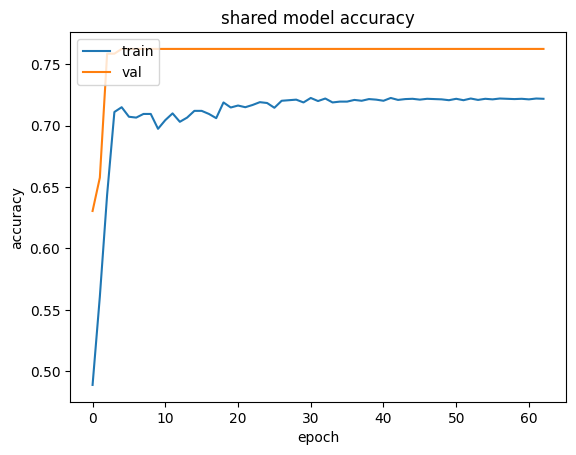

In [32]:
plot_shared(shared_history)

In [33]:
trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'shared_model.h5')
shared.save(trained_model)

c:\Users\20182009\Documents\Master DSAI\y2 q1\2IMI00 seminar process analytics\replicationStudy\.venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


##### Load Saved Model and Evaluate

In [34]:
shared_trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'shared_model.h5')
shared_model = load_model(shared_trained_model)

In [35]:
x_test,y_test = generate_inputs_shared(vec_test,args,indexes)

print("Evaluate on test data")

results = shared_model.evaluate(x_test, y_test, batch_size=100)
y_pred_shared = shared_model.predict(x_test)
print("test loss, test acc:", results)

Evaluate on test data
70/70 [==============================] - 4s 4ms/step
test loss, test acc: [0.5784578323364258, 0.7033016681671143]


Classification Report

In [36]:
target_names = [index_ne[i] for i in range(len(index_ne))]

print(classification_report(y_test.argmax(axis=1), y_pred_shared.argmax(axis=1), target_names=target_names))

                                              precision    recall  f1-score   support

                                  A_ACCEPTED       0.00      0.00      0.00       576
                        A_CANCELLED_DECLINED       0.00      0.00      0.00        80
W_Filling in information for the application       0.56      1.00      0.72       839
                      W_Fixing incoming lead       1.00      1.00      1.00       716

                                    accuracy                           0.70      2211
                                   macro avg       0.39      0.50      0.43      2211
                                weighted avg       0.54      0.70      0.60      2211



c:\Users\20182009\Documents\Master DSAI\y2 q1\2IMI00 seminar process analytics\replicationStudy\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\20182009\Documents\Master DSAI\y2 q1\2IMI00 seminar process analytics\replicationStudy\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\20182009\Documents\Master DSAI\y2 q1\2IMI00 seminar process analytics\replicationStudy\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-d

Confusion Matrix

[[  0   0 576   0]
 [  0   0  80   0]
 [  0   0 839   0]
 [  0   0   0 716]]


<Axes: >

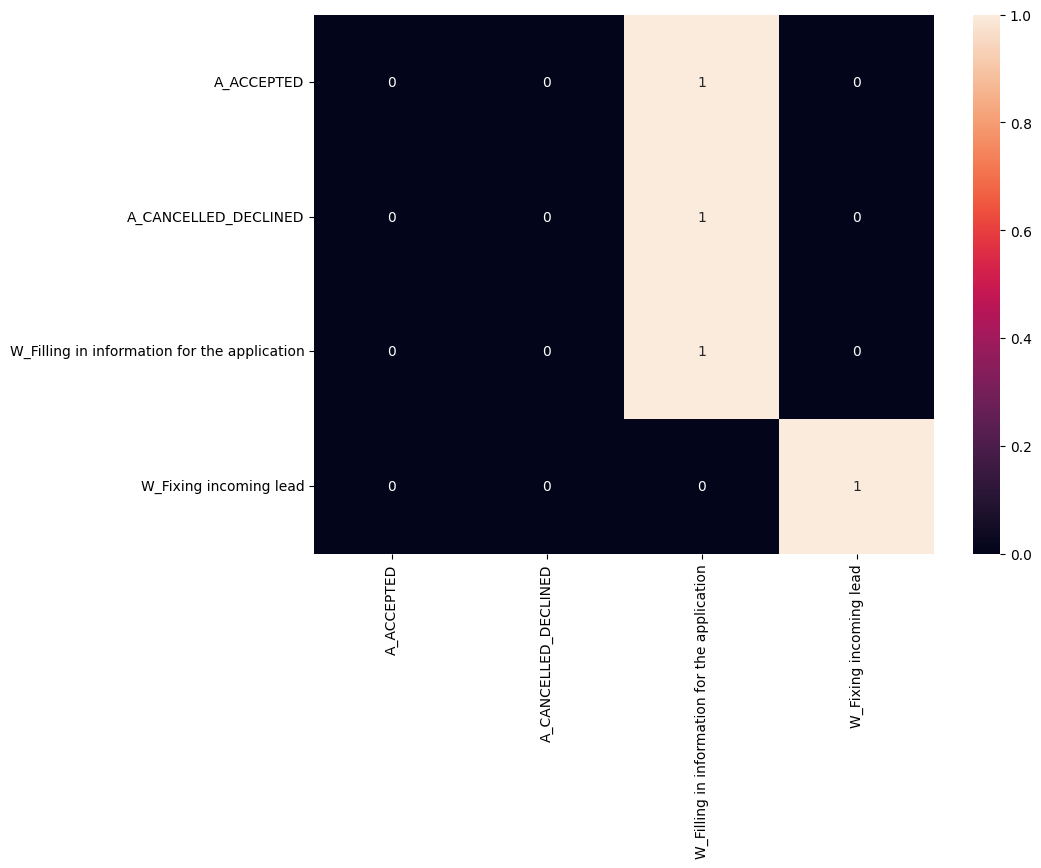

In [114]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred_shared.argmax(axis=1))
print(matrix)
matrix_sum = np.sum(matrix, axis=1).reshape(-1,1)
matrix_perc = matrix / matrix_sum
df_cm = pd.DataFrame(matrix_perc, index = [index_ne[i] for i in range(len(index_ne))],
                  columns = [index_ne[i] for i in range(len(index_ne))])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

##### Generating Explanations with Attention Layer

In [112]:
shared_model_attn_weights = Model(inputs=shared_model.input,
              outputs=[shared_model.output, shared_model.get_layer('timestep_attention').output, shared_model.get_layer('feature_importance').output])

shared_output_with_attention = shared_model_attn_weights.predict(x_test)

70/70 [==============================] - 3s 6ms/step


###### Global Explanations

In [116]:
shared_explain_global(shared_output_with_attention,x_test,y_test,index_ac,index_rl,3,prediction=3) #give the encoded number of the prediction target, not the string

###### Local Explanations

In [40]:
df_results_shared = results_df(y_test,y_pred_shared,index_ne)
df_results_shared [(df_results_shared ['prediction'] == 'W_Filling in information for the application') & (df_results_shared ['pred_class'] == True) & (df_results_shared ['prediction_prob'] >=0.5) ].head(3)

,sample_index,prediction,ground_truth,prediction_prob,pred_class
2,2,W_Filling in information for the application,W_Filling in information for the application,0.5651,True
3,3,W_Filling in information for the application,W_Filling in information for the application,0.5651,True
4,4,W_Filling in information for the application,W_Filling in information for the application,0.5651,True


In [41]:
shared_explain_local(shared_output_with_attention,x_test,y_test,index_ac, index_rl, index_ne, 3,9)


prediction: W_Filling in information for the application
ground truth: A_ACCEPTED
prediction probability:0.5651


process flowchart
st0=>start: start none_role:none
op1=>operation: none_role:none
op2=>operation: A_SUBMITTED_role:role_112
op3=>operation: A_PARTLYSUBMITTED_role:role_112
op4=>operation: A_PREACCEPTED_role:role_112

st0->op1
op1->op2
op2->op3
op3->op4





#### Specialised Model

In [42]:
specialised = specialised_model(vec_train, weights, indexes, pre_index, args)


In [43]:
specialised.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [44]:
specialised.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 ac_input (InputLayer)       [(None, 5, 6)]               0         []                            
                                                                                                  
 rl_input (InputLayer)       [(None, 5, 55)]              0         []                            
                                                                                                  
 t_input (InputLayer)        [(None, 5, 1)]               0         []                            
                                                                                                  
 beta_ac (Bidirectional)     (None, 5, 100)               22800     ['ac_input[0][0]']            
                                                                                            

In [45]:
batch_size = 256 # 32, 64, 128, 256
epochs = 100

In [46]:
specialised_history = specialised_model_fit(vec_train, specialised, indexes, pre_index, MY_WORKSPACE_DIR, batch_size, epochs, args)

This is the output file path  c:\Users\20182009\Documents\Master DSAI\y2 q1\2IMI00 seminar process analytics\replicationStudy\Shared-and-Specialised-Attention-based-Interpretable-Models\BPIC12\models\model_specialised_A_PREACCEPTED_{epoch:02d}-{val_loss:.2f}.h5
Epoch 1/100
18/18 [==============================] - 29s 345ms/step - loss: 1.3758 - accuracy: 0.3891 - val_loss: 1.3454 - val_accuracy: 0.2959 - lr: 0.0010
Epoch 2/100
18/18 [==============================] - 2s 91ms/step - loss: 1.3252 - accuracy: 0.4067 - val_loss: 1.2786 - val_accuracy: 0.2959 - lr: 0.0010
Epoch 3/100
18/18 [==============================] - 2s 87ms/step - loss: 1.2431 - accuracy: 0.4218 - val_loss: 1.1851 - val_accuracy: 0.2959 - lr: 0.0010
Epoch 4/100
18/18 [==============================] - 1s 69ms/step - loss: 1.1324 - accuracy: 0.6316 - val_loss: 1.0745 - val_accuracy: 0.7506 - lr: 0.0010
Epoch 5/100
18/18 [==============================] - 1s 70ms/step - loss: 1.0037 - accuracy: 0.6971 - val_loss: 0.94

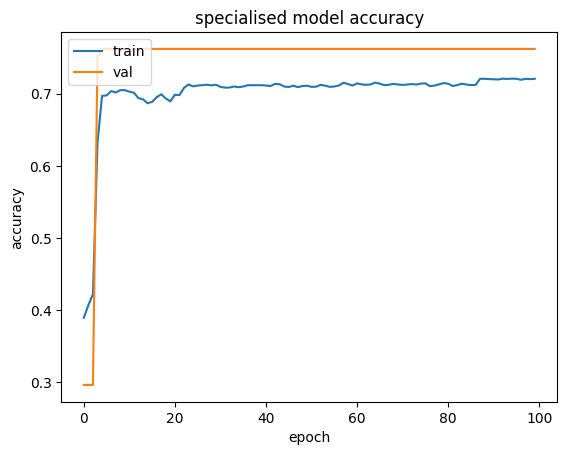

In [47]:
plot_specialised(specialised_history)

In [48]:
trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'specialised_model.h5')
specialised.save(trained_model)

c:\Users\20182009\Documents\Master DSAI\y2 q1\2IMI00 seminar process analytics\replicationStudy\.venv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



##### Load Saved Model and Evaluate

In [49]:
trained_model = os.path.join(os.path.join(MILESTONE_DIR, 'trained_models'),'specialised_model.h5')
specialised_model = load_model(trained_model)

Evaluating Prediction Performance

In [50]:
# Generating Inputs

x_test_ohe,y_test = generate_inputs(vec_test,args,indexes,experiment)

# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")

results = specialised_model.evaluate(x_test_ohe, y_test, batch_size=100)
y_pred = specialised_model.predict(x_test_ohe)
print("test loss, test acc:", results)

Evaluate on test data


70/70 [==============================] - 12s 13ms/step
test loss, test acc: [0.5976456999778748, 0.7010402679443359]


In [51]:
target_names = [index_ne[i] for i in range(len(index_ne))]

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

                                              precision    recall  f1-score   support

                                  A_ACCEPTED       0.00      0.00      0.00       576
                        A_CANCELLED_DECLINED       0.00      0.00      0.00        80
W_Filling in information for the application       0.56      1.00      0.72       839
                      W_Fixing incoming lead       1.00      0.99      1.00       716

                                    accuracy                           0.70      2211
                                   macro avg       0.39      0.50      0.43      2211
                                weighted avg       0.54      0.70      0.59      2211



c:\Users\20182009\Documents\Master DSAI\y2 q1\2IMI00 seminar process analytics\replicationStudy\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\20182009\Documents\Master DSAI\y2 q1\2IMI00 seminar process analytics\replicationStudy\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

c:\Users\20182009\Documents\Master DSAI\y2 q1\2IMI00 seminar process analytics\replicationStudy\.venv\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control

Confusion Matrix

[[  0   0 576   0]
 [  0   0  80   0]
 [  0   0 839   0]
 [  0   0   5 711]]


<Axes: >

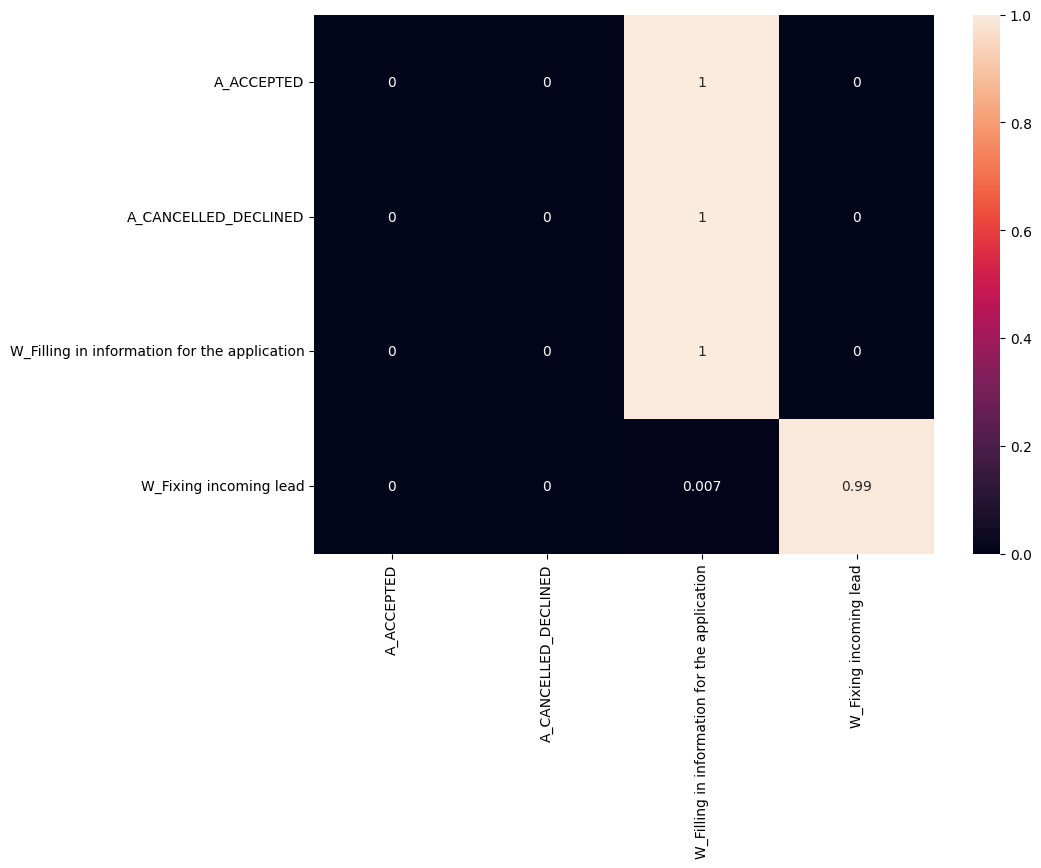

In [52]:
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)
matrix_sum = np.sum(matrix, axis=1).reshape(-1,1)
matrix_perc = matrix / matrix_sum
df_cm = pd.DataFrame(matrix_perc, index = [index_ne[i] for i in range(len(index_ne))],
                  columns = [index_ne[i] for i in range(len(index_ne))])

plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

##### Generating Explanations with Attention Layer

In [53]:
model_attn_weights = Model(inputs=specialised_model.input,
              outputs=[specialised_model.output, specialised_model.get_layer('timestep_attention').output,specialised_model.get_layer('ac_importance').output ,specialised_model.get_layer('rl_importance').output,specialised_model.get_layer('t_importance').output])

output_with_attention = model_attn_weights.predict(x_test_ohe)

70/70 [==============================] - 10s 13ms/step


###### Global Explanations

In [100]:
explain_global(output_with_attention,x_test,y_test,index_ac, index_rl,3,prediction=3)

###### Local Explanations

In [55]:
df_results = results_df(y_test,y_pred,index_ne)
df_results [(df_results ['ground_truth'] == 'A_ACCEPTED') & (df_results ['pred_class'] == False) & (df_results ['prediction_prob'] >=0.5) ].head(10)

,sample_index,prediction,ground_truth,prediction_prob,pred_class
0,0,W_Filling in information for the application,A_ACCEPTED,0.5612,False
1,1,W_Filling in information for the application,A_ACCEPTED,0.5612,False
9,9,W_Filling in information for the application,A_ACCEPTED,0.5612,False
10,10,W_Filling in information for the application,A_ACCEPTED,0.5612,False
20,20,W_Filling in information for the application,A_ACCEPTED,0.5612,False
25,25,W_Filling in information for the application,A_ACCEPTED,0.5612,False
26,26,W_Filling in information for the application,A_ACCEPTED,0.5612,False
33,33,W_Filling in information for the application,A_ACCEPTED,0.5612,False
34,34,W_Filling in information for the application,A_ACCEPTED,0.5612,False
40,40,W_Filling in information for the application,A_ACCEPTED,0.5612,False


In [56]:
df_temp = df_results [(df_results ['ground_truth'] == 'W_Filling in information for the application') & (df_results ['pred_class'] == True)  ]
df_temp['prediction_prob'].mode()

0    0.5612
Name: prediction_prob, dtype: float32

In [102]:
explain_local(output_with_attention,x_test,y_test,index_ac,index_rl,index_ne,3,9)

prediction: W_Filling in information for the application
ground truth: A_ACCEPTED
prediction probability:0.5612


process flowchart
st96=>start: start none
op97=>operation: none_none
op98=>operation: A_SUBMITTED_role_112
op99=>operation: A_PARTLYSUBMITTED_role_112
op100=>operation: A_PREACCEPTED_role_112

st96->op97
op97->op98
op98->op99
op99->op100



